# Trees

In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4 as n
%matplotlib inline
from utils import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

## Read the data

Working with netcdf files.

http://unidata.github.io/netcdf4-python/

### Norway

We are not going to use these data (we use files for Europe).

In [2]:
path = "./files/"
filenames = ["specific_humidity_Norway.nc", "relative_humidity_Norway.nc", "pressure_Norway.nc",  
             "temperature_Norway.nc", "total_cloud_cover_Norway.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

files_nor = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}

In [3]:
#print(pressure.variables)
tcc_nor = cloud.variables["tcc"]
rh_nor = relative.variables["r"]
# level = relative.variables["level"]
q_nor = specific.variables["q"]
sp_nor = pressure.variables["sp"]
t2m_nor = temperature.variables["t2m"]

### Europe
We use only the first time stamp, and level 1000 hPa.

#### Open files

In [4]:
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

my_files = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}

#### Variables

In [5]:
for key, value in my_files.items():
    print(key, ': ', value.variables)

cloud :  OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (77,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (61,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:0.0
    long_name: time
    calendar: gregorian
unlimited dimensions: time
current shape = (32,)
filling on, default _FillValue of -2147483647 used
), ('tcc', <class 'netCDF4._netCDF4.Variable'>
int16 tcc(time, latitude, longitude)
    scale_factor: 1.525948758640685e-05
    add_offset: 0.49999237025720666
    _FillValue: -32767
    missing_value: -32767
    units: (0 - 1)
    long_name: Total cloud co

In [6]:
tcc = cloud.variables["tcc"]
rh = relative.variables["r"]
q = specific.variables["q"]
sp = pressure.variables["sp"]
t2m = temperature.variables["t2m"]

my_vars = {'tcc':tcc, 'rh':rh, 'q':q, 'sp':sp, 't2m':t2m}

#### Dimensions and sizes?

In [7]:
for key, value in my_files.items():
    print(key, ': ', value.dimensions)

cloud :  OrderedDict([('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 77
), ('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 61
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 32
)])
relative :  OrderedDict([('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 77
), ('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 61
), ('level', <class 'netCDF4._netCDF4.Dimension'>: name = 'level', size = 6
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 32
)])
specific :  OrderedDict([('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 77
), ('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 61
), ('level', <class 'netCDF4._netCDF4.Dimension'>: name = 'level', size = 6
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 32
)])
pressure

In [8]:
for key, value in my_vars.items():
    print(key, ': ', value.dimensions)

tcc :  ('time', 'latitude', 'longitude')
rh :  ('time', 'level', 'latitude', 'longitude')
q :  ('time', 'level', 'latitude', 'longitude')
sp :  ('time', 'latitude', 'longitude')
t2m :  ('time', 'latitude', 'longitude')


#### Levels

In [9]:
print('rh levels: ', relative['level'][:])
print('q levels: ', specific['level'][:])

rh levels:  [1000  850  700  500  400  300]
q levels:  [1000  850  700  500  400  300]


In [10]:
print('Units for the latitude:', relative.variables['latitude'].units)
print('Units for the longitude:', relative.variables['longitude'].units)
print('Units for the time:', relative.variables['time'].units)
print('Units for the level:', relative.variables['level'].units)

Units for the latitude: degrees_north
Units for the longitude: degrees_east
Units for the time: hours since 1900-01-01 00:00:0.0
Units for the level: millibars


#### Check whether data is corrected for offset and scale_factor

In [11]:
for key, value in my_vars.items():
    test = value.scale
    print(test)
    

True
True
True
True
True


## Write array with data for 1000 hPa, first time stamp

In [12]:
print(tcc.shape)
print(rh.shape)
print(q.shape)
print(sp.shape)
print(t2m.shape)


(32, 61, 77)
(32, 6, 61, 77)
(32, 6, 61, 77)
(32, 61, 77)
(32, 61, 77)


In [13]:
X = np.empty((tcc.shape[1]*tcc.shape[2], 4))
y = np.empty((tcc.shape[1]*tcc.shape[2], 1))

i=0
for key, value in my_vars.items():
    if key == 'tcc':
        y = np.array(value[0, : , :]).flatten()
    elif key == 'rh' or key == 'q':
        X[:, i] = np.array(value[0, 0, : , :]).flatten()
        i = i+1
    else:
        X[:, i] = np.array(value[0, : , :]).flatten()
        i=i+1

#my_vars['tcc'] = tcc[1, :, :]
#my_vars['rh'] = rh[1, 1, :, :]
#my_vars['q'] = q[1, 1, :, :]
#my_vars['sp'] = sp[1, :, :]
#my_vars['t2m'] = t2m[1, :, :]

In [14]:
X[0:10,:]

array([[9.67092498e+01, 7.89155626e-04, 1.00881369e+05, 2.54531033e+02],
       [9.58529196e+01, 8.08777750e-04, 1.00877530e+05, 2.55042680e+02],
       [9.56865236e+01, 8.45675872e-04, 1.00848736e+05, 2.56260888e+02],
       [9.60416369e+01, 8.82787279e-04, 1.00819942e+05, 2.57480033e+02],
       [9.64819773e+01, 9.38027821e-04, 1.00793451e+05, 2.59043087e+02],
       [9.65509708e+01, 1.04573621e-03, 1.00786925e+05, 2.60489006e+02],
       [9.59746727e+01, 1.15387118e-03, 1.00780014e+05, 2.61934925e+02],
       [9.47733753e+01, 1.27160391e-03, 1.00769264e+05, 2.63318059e+02],
       [9.32210230e+01, 1.40192040e-03, 1.00756211e+05, 2.64518462e+02],
       [9.16909922e+01, 1.53074391e-03, 1.00743926e+05, 2.65704809e+02]])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.5)

### Fit tree

In [16]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

### Predict tree


In [17]:
y_pred = clf.predict(X_test)

In [18]:
msq_t1 = metrics.mean_squared_error(y_test, y_pred)
msq_t1

0.10302699162825392

In [19]:
r2_t1 = metrics.r2_score(y_test, y_pred)
r2_t1

0.20006346019983556

#### With normalize the data

In [20]:
# Xn = preprocessing.normalize(X)
# yn = preprocessing.normalize(y.reshape(-1, 1))
Xn = (X - X.mean())/X.std()
yn = (y - y.mean())/y.std()

Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, split_size=0.3)


##### Max depth

In [21]:
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for depth in range(1,20):

    clf = tree.DecisionTreeRegressor(max_depth=depth)
    clf = clf.fit(Xn_train, yn_train)

    yn_pred_test = clf.predict(Xn_test)
    yn_pred_train = clf.predict(Xn_train)

    mse_train.append(metrics.mean_squared_error(yn_train, yn_pred_train))
    mse_test.append(metrics.mean_squared_error(yn_test, yn_pred_test))

    r2_train.append(metrics.r2_score(yn_train, yn_pred_train))
    r2_test.append(metrics.r2_score(yn_test, yn_pred_test))

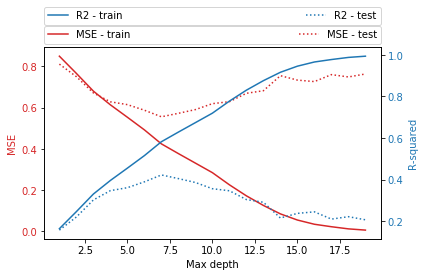

In [22]:
x = np.arange(19)+1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Max depth')
ax1.set_ylabel('MSE', color=color)
ax1.plot(x, mse_train, color=color, label='MSE - train')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(x, mse_test, color=color, linestyle = ':', label='MSE - test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R-squared', color=color)  # we already handled the x-label with ax1
ax2.plot(x, r2_train, color=color, label='R2 - train')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(x, r2_test, color=color, linestyle = ':', label='R2 - test')
#ax2.invert_yaxis()

plt.legend(bbox_to_anchor=(0., 1.12, 1., 0.102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.30, 0.8), loc=2, borderaxespad=0.)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

##### Max leaf nodes

In [24]:
mse_train = []
mse_test = []
r2_train = []
r2_test = []
for leaves in range(2,40):

    clf = tree.DecisionTreeRegressor(max_depth=4, max_leaf_nodes=leaves)
    clf = clf.fit(Xn_train, yn_train)

    yn_pred_test = clf.predict(Xn_test)
    yn_pred_train = clf.predict(Xn_train)

    mse_train.append(metrics.mean_squared_error(yn_train, yn_pred_train))
    mse_test.append(metrics.mean_squared_error(yn_test, yn_pred_test))

    r2_train.append(metrics.r2_score(yn_train, yn_pred_train))
    r2_test.append(metrics.r2_score(yn_test, yn_pred_test))

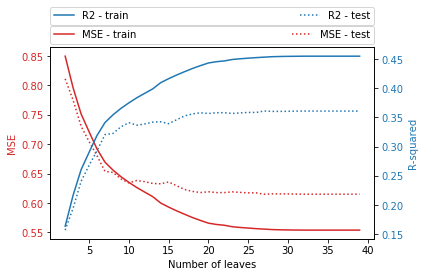

In [25]:
x = np.arange(38)+2
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of leaves')
ax1.set_ylabel('MSE', color=color)
ax1.plot(x, mse_train, color=color, label='MSE - train')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(x, mse_test, color=color, linestyle = ':', label='MSE - test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R-squared', color=color)  # we already handled the x-label with ax1
ax2.plot(x, r2_train, color=color, label='R2 - train')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(x, r2_test, color=color, linestyle = ':', label='R2 - test')
#ax2.invert_yaxis()

plt.legend(bbox_to_anchor=(0., 1.12, 1., 0.102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.30, 0.8), loc=2, borderaxespad=0.)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Select max_depth=4, max_leaf_nodes==7

In [26]:
"""# Plot the results

x = x = np.arange(yn_test.shape[0] )
plt.figure()
plt.scatter(x, yn_test, color="darkorange", label="data")
plt.plot(x, yn_pred_test, color="cornflowerblue",
         label="Prediction", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()"""

'# Plot the results\n\nx = x = np.arange(yn_test.shape[0] )\nplt.figure()\nplt.scatter(x, yn_test, color="darkorange", label="data")\nplt.plot(x, yn_pred_test, color="cornflowerblue",\n         label="Prediction", linewidth=2)\nplt.xlabel("data")\nplt.ylabel("target")\nplt.title("Decision Tree Regression")\nplt.legend()\nplt.show()'

### Plot results

In [27]:
"""import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("") """

'import graphviz \ndot_data = tree.export_graphviz(clf, out_file=None) \ngraph = graphviz.Source(dot_data) \ngraph.render("") '

# Random forest

In [28]:
regr = RandomForestRegressor()
regr.fit(Xn_train, yn_train)
y_pred_test = regr.predict(Xn_test)
print('MSE', metrics.mean_squared_error(yn_train, yn_pred_train))
print('R2', metrics.r2_score(yn_train, yn_pred_train))

MSE 0.5537023515151368
R2 0.4550583196994281


C:\Users\nbpst2\Anaconda3\envs\negi_course2\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Max depth

In [33]:
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for depth in range(1,20):

    regr = RandomForestRegressor(max_depth=depth)
    regr.fit(Xn_train, yn_train)
    yn_pred_test = regr.predict(Xn_test)
    yn_pred_train = regr.predict(Xn_train)

    mse_train.append(metrics.mean_squared_error(yn_train, yn_pred_train))
    mse_test.append(metrics.mean_squared_error(yn_test, yn_pred_test))

    r2_train.append(metrics.r2_score(yn_train, yn_pred_train))
    r2_test.append(metrics.r2_score(yn_test, yn_pred_test))

C:\Users\nbpst2\Anaconda3\envs\negi_course2\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\nbpst2\Anaconda3\envs\negi_course2\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\nbpst2\Anaconda3\envs\negi_course2\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\nbpst2\Anaconda3\envs\negi_course2\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


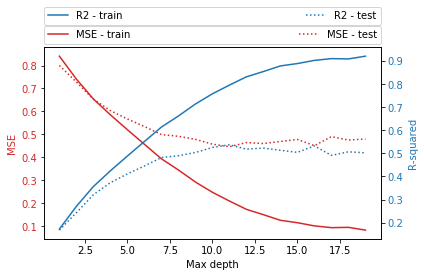

In [34]:
x = np.arange(19)+1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Max depth')
ax1.set_ylabel('MSE', color=color)
ax1.plot(x, mse_train, color=color, label='MSE - train')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(x, mse_test, color=color, linestyle = ':', label='MSE - test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R-squared', color=color)  # we already handled the x-label with ax1
ax2.plot(x, r2_train, color=color, label='R2 - train')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(x, r2_test, color=color, linestyle = ':', label='R2 - test')
#ax2.invert_yaxis()

plt.legend(bbox_to_anchor=(0., 1.12, 1., 0.102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.30, 0.8), loc=2, borderaxespad=0.)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Number of estimators

In [31]:
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for nestim in range(1,20):

    regr = RandomForestRegressor(max_depth=7, n_estimators=nestim)
    regr.fit(Xn_train, yn_train)
    yn_pred_test = regr.predict(Xn_test)
    yn_pred_train = regr.predict(Xn_train)

    mse_train.append(metrics.mean_squared_error(yn_train, yn_pred_train))
    mse_test.append(metrics.mean_squared_error(yn_test, yn_pred_test))

    r2_train.append(metrics.r2_score(yn_train, yn_pred_train))
    r2_test.append(metrics.r2_score(yn_test, yn_pred_test))

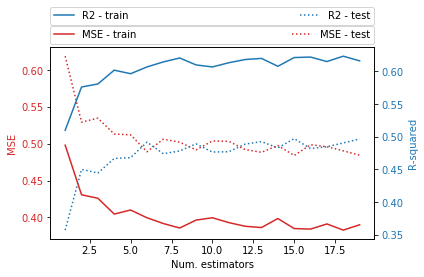

In [32]:
x = np.arange(19)+1
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Num. estimators')
ax1.set_ylabel('MSE', color=color)
ax1.plot(x, mse_train, color=color, label='MSE - train')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(x, mse_test, color=color, linestyle = ':', label='MSE - test')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R-squared', color=color)  # we already handled the x-label with ax1
ax2.plot(x, r2_train, color=color, label='R2 - train')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(x, r2_test, color=color, linestyle = ':', label='R2 - test')
#ax2.invert_yaxis()

plt.legend(bbox_to_anchor=(0., 1.12, 1., 0.102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.30, 0.8), loc=2, borderaxespad=0.)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()